В файле dataset.csv можно найти синтетическую выборку. Она содержит 5 признаков и целевую переменную.

Требуется обучить на этих данных классификатор с как можно более высокой обобщающей способностью.
Метрикой, по которой будет оцениваться качество классификатора, является ROC-AUC.
Стоит заранее отметить, что если не удаётся получить ROC-AUC выше 70%, то это означает, что не придуманы какие-то сильные признаки.
При этом предлагается уделить внимание не только точности классификатора, но и оформлению кода, изучению данных и грамотной оценке качества получившейся модели
всё это тоже будет оцениваться, а что-то из этого также может помочь построить более хорошую модель.
Гарантируется, что можно получить 100% точность классификации

Решение необходимо сдать в виде скрипта на Python или блокнота формата Jupyter Notebook. Комментарии и графики приветствуются.




In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("C:/Users/Mr0Wo/OneDrive/Рабочий стол/Git_repositories/Data-science-cases/ML-cases/synthetic-feature-engineering/dataset-circles - dataset.csv")

In [3]:
df

feature_1  feature_2  feature_3  feature_4  feature_5  target
0      0.433306  -4.106981   1.252722   4.842634   7.610817       1
1     -0.216705   3.832332 -10.054348  -1.106758   1.987823       0
2      8.574821  -2.495187   5.404009  -6.219058   6.954602       1
3      7.673529  -4.234502   8.135008   3.748393   3.457908       0
4      3.548824  -2.588106  -2.095070   7.993792  -3.523852       1
...         ...        ...        ...        ...        ...     ...
2995 -10.510055   1.447894  -0.138512   0.918843   2.752979       0
2996  -9.802423  -5.085255   1.041877   4.370925   5.182877       0
2997  -6.332143  -0.315068   7.340215  -4.111093   5.746726       1
2998  -1.516059  -3.697544   9.363563  -0.907570   4.065678       0
2999  11.103381   3.456086  -1.372107  -2.292011  -1.278436       1

[3000 rows x 6 columns]

# EDA

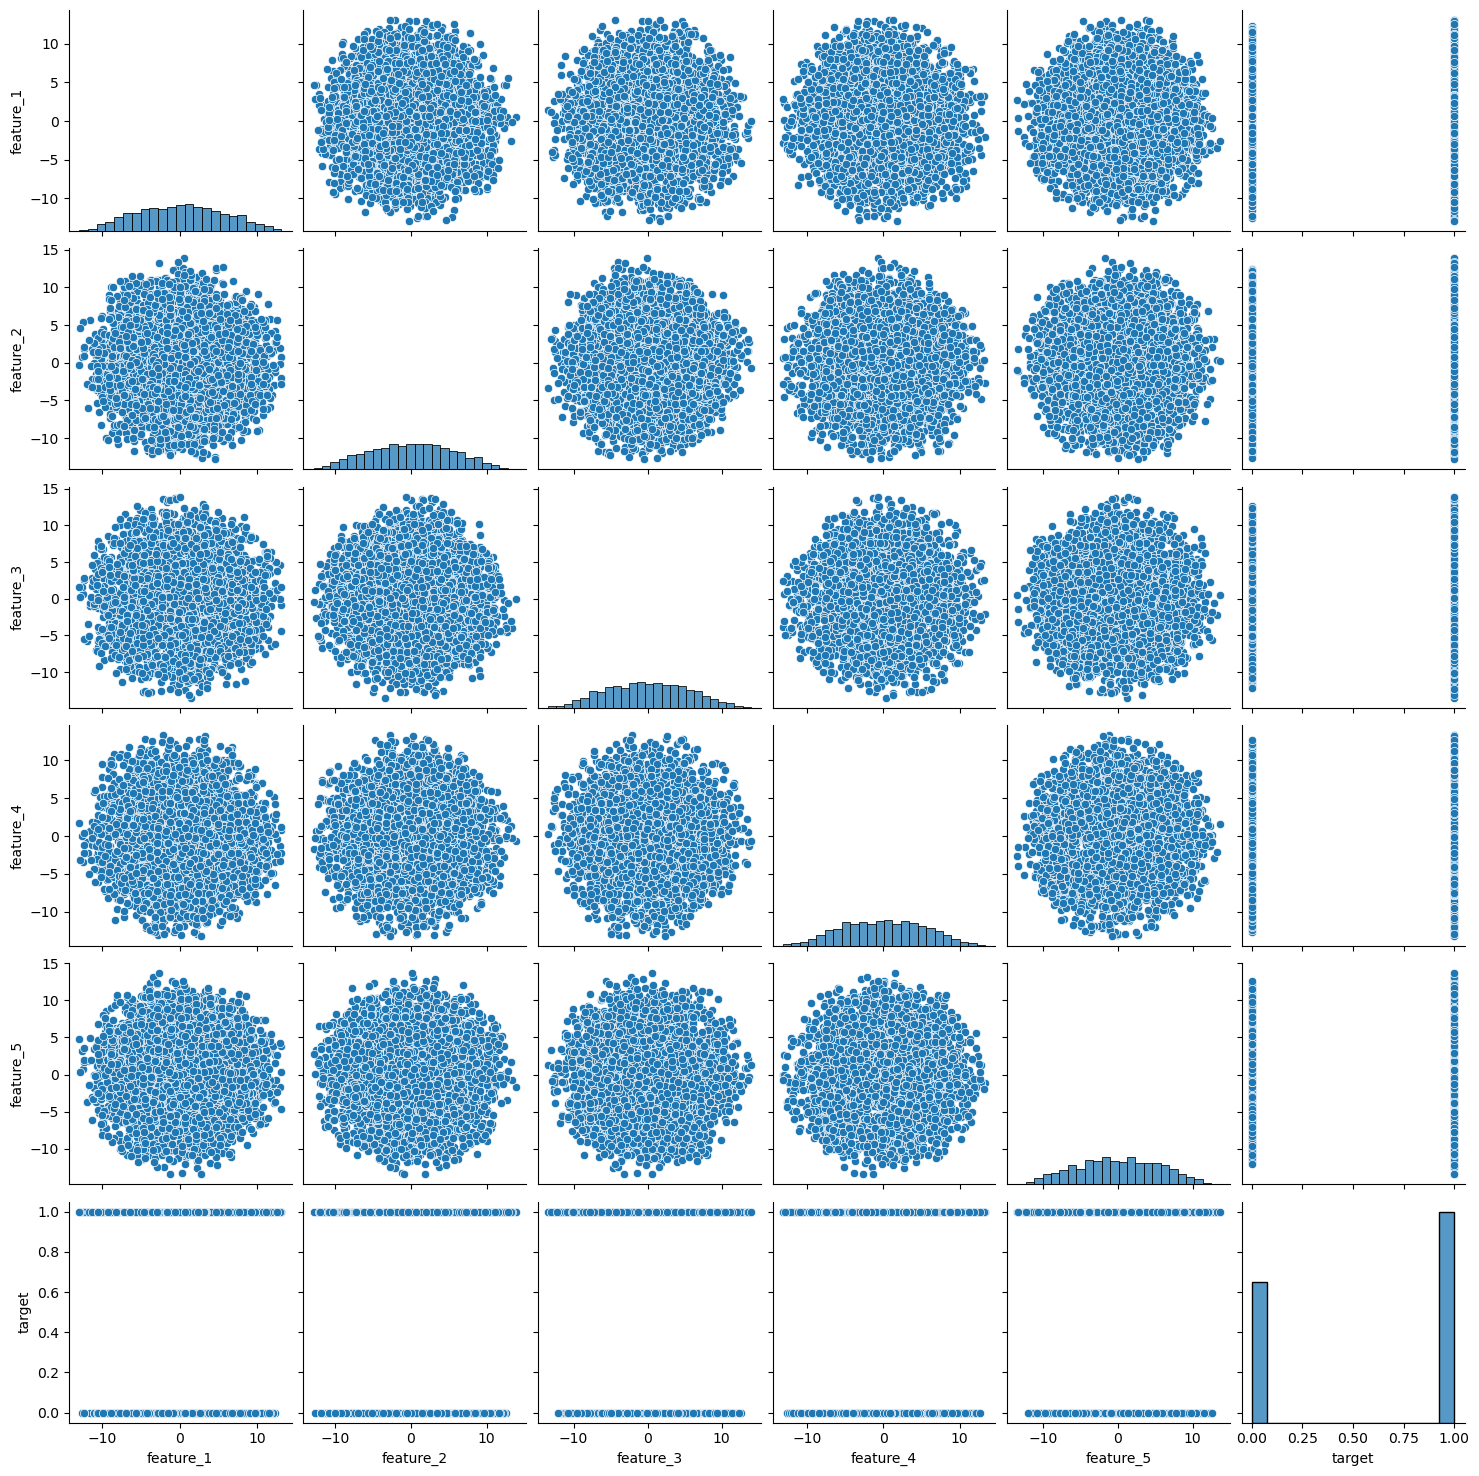

In [4]:
sns.pairplot(df)

<Axes: >

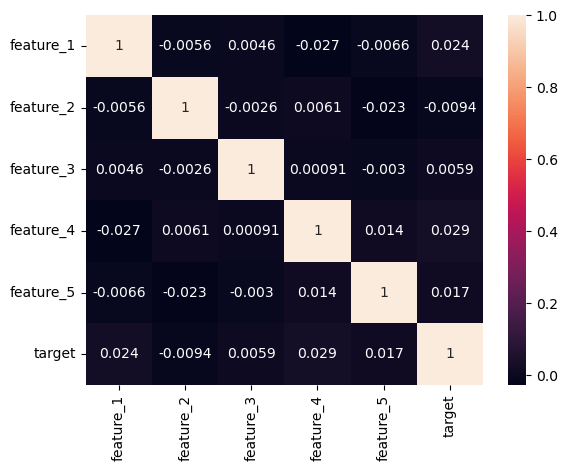

In [5]:
sns.heatmap(df.corr(), annot=True)

Видно, что никакой корреляции между признаками нет. Все признаки по отношению друг к другу - облака точек  
Обучать модель на этих данных бесполезно, точность будет ~50%

Если в условии задачи гарантируется, что можно достичь 100% рок-аук, следовательно в данных есть скрытая взаимосвязь. Не думаю, что есть смысл генерирования большого кол-ва фич с всеми возможными авриантами премножения, деления, сложения, вычитания фич

Попробуем снизить размерность данных с 5 то 2

In [7]:
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding

In [8]:
test_df = df.iloc[:1500]

In [10]:
isomap = Isomap(n_components=2)
mds = MDS(n_components=2)
tsne = TSNE(n_components=2)
local_LE = LocallyLinearEmbedding(n_components=2)

In [12]:
df_transformed_iso = pd.DataFrame(isomap.fit_transform(test_df.drop('target', axis=1)))
df_transformed_mds = pd.DataFrame(mds.fit_transform(test_df.drop('target', axis=1)))
df_transformed_tsne = pd.DataFrame(tsne.fit_transform(test_df.drop('target', axis=1)))
df_transformed_lle = pd.DataFrame(local_LE.fit_transform(test_df.drop('target', axis=1)))

C:\Users\Mr0Wo\anaconda3\envs\MLDP\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


[Text(0.5, 1.0, 'LocalLE')]

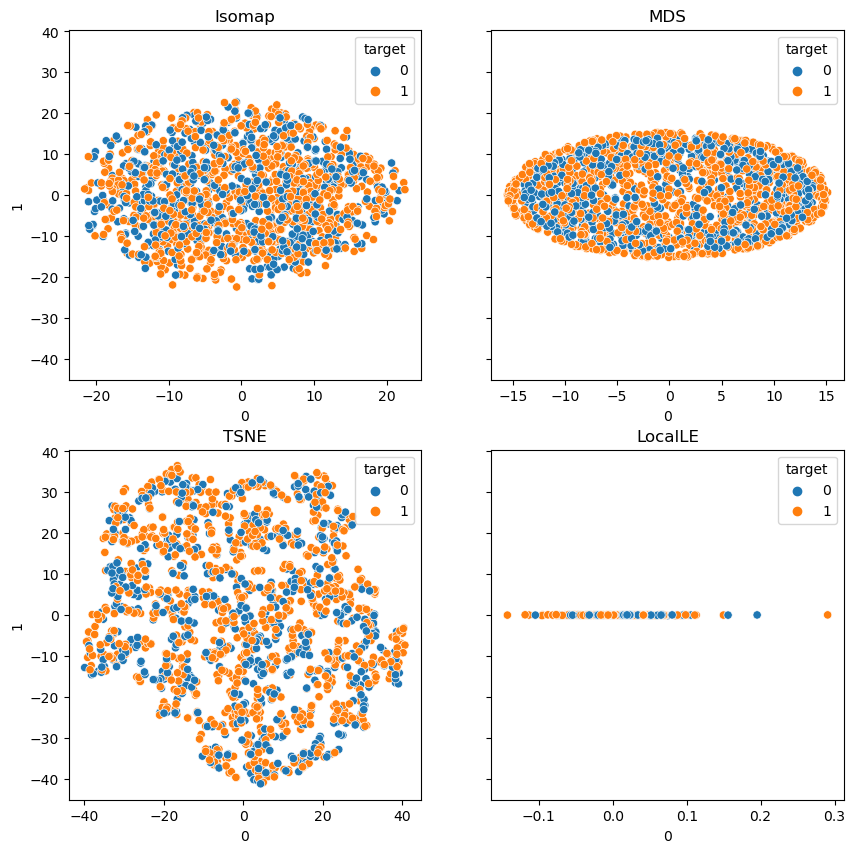

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

sns.scatterplot(ax=axes[0,0], x=df_transformed_iso[0], y=df_transformed_iso[1], hue=df['target']).set(title='Isomap')
sns.scatterplot(ax=axes[0,1], x=df_transformed_mds[0], y=df_transformed_mds[1], hue=df['target']).set(title='MDS')
sns.scatterplot(ax=axes[1,0], x=df_transformed_tsne[0], y=df_transformed_tsne[1], hue=df['target']).set(title='TSNE')
sns.scatterplot(ax=axes[1,1], x=df_transformed_lle[0], y=df_transformed_lle[1], hue=df['target']).set(title='LocalLE')

MDS выдал интересный результат, на графике видно, что из 1 класса образовался эллипс, за которым идет уже другой эллипс из 0 класса

При помощи MDS посторим 3-х мерную проектцию наших данных

In [20]:
mds_3d = MDS(n_components=3)
df_transformed_3d = pd.DataFrame(mds_3d.fit_transform(test_df.drop('target', axis=1)))

C:\Users\Mr0Wo\anaconda3\envs\MLDP\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [22]:
df_transformed_3d.rename(columns={0:'x1', 1:'x2', 2:'x3'},inplace=True)
df_transformed_3d['target'] = df['target']

In [25]:
import plotly.express as px
fig = px.scatter_3d(df_transformed_3d, x='x1', y='x2', z='x3', color='target')
fig.show()

На 3-х мерном графики видим ту же ситуцаю, первый класс создает сферу, внутри которой, по всей видимости, вложены другие сферы  
Можно сделать вывод, что данные представляют из себя вложенные сферы, находящиеся в 5-мерном измерении 

Т.к. мы имеем дело со вложенными сферами, то их можно будет разграничить при помощи ново фичи:   
растоянни между точками в простанстве  
Из графика видно, что центр координат находится в точке O(0,0,0), соответственно во всех измерениях эта точка будет O(0...0)

# Feature Engineering 

In [27]:
df['my_feature'] = np.sqrt(df.feature_1 ** 2 + df.feature_2 ** 2 + df.feature_3 ** 2 + df.feature_4 ** 2 + df.feature_5 ** 2)

In [28]:
df

feature_1  feature_2  feature_3  feature_4  feature_5  target  \
0      0.433306  -4.106981   1.252722   4.842634   7.610817       1   
1     -0.216705   3.832332 -10.054348  -1.106758   1.987823       0   
2      8.574821  -2.495187   5.404009  -6.219058   6.954602       1   
3      7.673529  -4.234502   8.135008   3.748393   3.457908       0   
4      3.548824  -2.588106  -2.095070   7.993792  -3.523852       1   
...         ...        ...        ...        ...        ...     ...   
2995 -10.510055   1.447894  -0.138512   0.918843   2.752979       0   
2996  -9.802423  -5.085255   1.041877   4.370925   5.182877       0   
2997  -6.332143  -0.315068   7.340215  -4.111093   5.746726       1   
2998  -1.516059  -3.697544   9.363563  -0.907570   4.065678       0   
2999  11.103381   3.456086  -1.372107  -2.292011  -1.278436       1   

      my_feature  
0           10.0  
1           11.0  
2           14.0  
3           13.0  
4           10.0  
...          ...  
2995        11.0  
2996        13.0  
2997        12.0  
2998        11.0  
2999        12.0  

[3000 rows x 7 columns]

In [30]:
cb_model = CatBoostClassifier(verbose=100)
y = df.target
X = df.drop('target', axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [32]:
cb_model.fit(X_train, y_train)

C:\Users\Mr0Wo\anaconda3\envs\MLDP\lib\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Learning rate set to 0.014142
0:	learn: 0.6518645	total: 152ms	remaining: 2m 31s
100:	learn: 0.0073908	total: 342ms	remaining: 3.05s
200:	learn: 0.0015023	total: 534ms	remaining: 2.12s
300:	learn: 0.0008016	total: 784ms	remaining: 1.82s
400:	learn: 0.0006276	total: 1.01s	remaining: 1.51s
500:	learn: 0.0005996	total: 1.21s	remaining: 1.21s
600:	learn: 0.0005944	total: 1.37s	remaining: 911ms
700:	learn: 0.0005943	total: 1.53s	remaining: 653ms
800:	learn: 0.0005941	total: 1.69s	remaining: 419ms
900:	learn: 0.0005939	total: 1.84s	remaining: 203ms
999:	learn: 0.0005937	total: 2s	remaining: 0us


In [33]:
y_pred = cb_model.predict(X_test)

In [34]:
roc_auc_score(y_test, y_pred)

1.0